# Inspiration
- https://medium.com/@xjurajkmec/pairwise-learning-for-neural-link-prediction-f1d16a0d28f6#:~:text=The%20idea%20of%20using%20graph,edges%20in%20the%20given%20graph

In [1]:
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from torch import torch
from sklearn import preprocessing

from torch_geometric.data import Data
from torch_geometric.transforms.to_undirected import ToUndirected

In [2]:
postings_1 = pd.read_csv("../data/Postings_01052019_15052019.csv", sep = ';')
postings_2 = pd.read_csv("../data/Postings_16052019_31052019.csv", sep = ';')
votes_1 = pd.read_csv("../data/Votes_01052019_15052019.csv", sep = ';')
votes_2 = pd.read_csv("../data/Votes_16052019_31052019.csv", sep = ';')
postings = pd.concat([postings_1, postings_2])
votes = pd.concat([votes_1, votes_2])

In [3]:
post_article = postings.groupby(by = ['ID_CommunityIdentity', 'ID_Article']).agg({"ArticlePublishingDate": "min"})
post_article = post_article.reset_index()
votes_trunc = votes[['ID_CommunityIdentity', 'ID_Posting']]
postings_trunc = postings.groupby(by = ['ID_Posting', 'ID_Article']).agg({"ArticlePublishingDate": "min"}).reset_index().drop(columns = ['ArticlePublishingDate'])
vote_user_article = votes_trunc.merge(postings_trunc, left_on = ['ID_Posting'], right_on = ['ID_Posting'])
vote_article = vote_user_article.groupby(by = ['ID_CommunityIdentity', 'ID_Article']).agg({"ID_Posting": "count"}).reset_index().drop(columns = ['ID_Posting'])
user_article_interaction = pd.concat([post_article, vote_article]).drop(columns=['ArticlePublishingDate'])

In [4]:
user_article_interaction

,ID_CommunityIdentity,ID_Article
0,30,2000102732845
1,30,2000103774090
2,30,2000104101028
3,38,2000102598376
4,38,2000102673879
...,...,...
744100,694465,2000104075987
744101,694465,2000104146249
744102,694495,2000103409863
744103,694509,2000103983635


In [5]:
user_article_interaction = user_article_interaction.groupby(by = ['ID_CommunityIdentity', 'ID_Article']).count().reset_index()

In [6]:
user_article_interaction

,ID_CommunityIdentity,ID_Article
0,4,2000102804423
1,4,2000103055571
2,4,2000104090194
3,30,2000102344996
4,30,2000102396881
...,...,...
895191,694484,2000103705203
895192,694495,2000103409863
895193,694509,2000103983635
895194,694512,2000103990942


In [7]:
user_article_interaction["user_id"] = "u-" + user_article_interaction["ID_CommunityIdentity"].astype(str)
user_article_interaction["article_id"] = "a-" + user_article_interaction["ID_Article"].astype(str)


user_article_interaction_subsampled = user_article_interaction.sample(n=int(user_article_interaction.shape[0]/2), random_state=1)

# concatenate nodes and create node encodings
nodes = np.concatenate((np.unique(user_article_interaction_subsampled['user_id']), np.unique(user_article_interaction_subsampled['article_id'])))
nodes_user = np.unique(user_article_interaction_subsampled['user_id'])
nodes_article = np.unique(user_article_interaction_subsampled['article_id'])

In [8]:


label_encoder_nodes = preprocessing.LabelEncoder()
label_encoder_nodes.fit(nodes)
nodes_enc = label_encoder_nodes.transform(nodes)

user_article_interaction_subsampled['user_id_enc'] = label_encoder_nodes.transform(user_article_interaction_subsampled['user_id'])
user_article_interaction_subsampled['article_id_enc'] = label_encoder_nodes.transform(user_article_interaction_subsampled['article_id'])


In [9]:
user_article_interaction_subsampled

,ID_CommunityIdentity,ID_Article,user_id,article_id,user_id_enc,article_id_enc
491561,537794,2000103382534,u-537794,a-2000103382534,17073,2572
357185,499795,2000102978401,u-499795,a-2000102978401,12298,1646
414148,511521,2000102625670,u-511521,a-2000102625670,14314,855
601634,574781,2000103767649,u-574781,a-2000103767649,21032,3408
319857,238360,2000103916256,u-238360,a-2000103916256,10099,3725
...,...,...,...,...,...,...
706299,632037,2000102386715,u-632037,a-2000102386715,24576,276
527994,551362,2000102517787,u-551362,a-2000102517787,18445,612
250387,189697,2000103803906,u-189697,a-2000103803906,7940,3490
478043,532935,2000103471066,u-532935,a-2000103471066,16626,2732


In [1]:
# generate edge list
edge_list = []
for row in user_article_interaction_subsampled.itertuples():
    edge_list.append([row.user_id_enc, row.article_id_enc])

# create tensor with nodes
x = torch.tensor(nodes_enc, dtype=torch.long)

NameError: name 'user_article_interaction_subsampled' is not defined

In [36]:
# create tensor with edges
edge_index = torch.tensor(edge_list, dtype=torch.long)

# initialize graph with nodes and edges
graph = Data(x=x, edge_index=edge_index.t())

# validate graph
graph.validate(raise_on_error=True)
# graph = ToUndirected()(graph)

True

In [37]:
# graph = ToUndirected()(graph)

True

In [28]:
len(np.unique(graph.edge_index[0]))

33557

In [29]:
len(np.unique(graph.edge_index[1]))

33557

In [24]:
graph.edge_index[1]

tensor([2572, 1646,  855,  ..., 3490, 2732, 3228])

In [26]:
graph.edge_index[0]

tensor([17073, 12298, 14314,  ...,  7940, 16626,  8520])

# Modelling with graphSAGE GNN

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric as pyg
from torch_geometric.loader import DataLoader
from torch_geometric.utils import negative_sampling
from ogb.linkproppred import PygLinkPropPredDataset, Evaluator 
from torch_geometric.transforms import RandomLinkSplit, RandomNodeSplit
import matplotlib.pyplot as plt 
import numpy as np 

import subprocess as sp
import os
from tqdm import tqdm


In [29]:
from graphsage.graphsage import GNNStack, LinkPredictor, train, test

In [30]:
class GNNStack(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout, emb=False):
        super(GNNStack, self).__init__()

        # GraphSAGE convolutional layers
        conv_model = pyg.nn.SAGEConv
        # conv_model = pyg.nn.GATConv


        self.convs = nn.ModuleList()

        # add the first convolutional layer
        self.convs.append(conv_model(input_dim, hidden_dim))
        self.dropout = dropout
        self.num_layers = num_layers
        self.emb = emb

        # Create num_layers GraphSAGE convs
        assert (self.num_layers >= 1), 'Number of layers is not >=1'
        for l in range(self.num_layers - 1):
            self.convs.append(conv_model(hidden_dim, hidden_dim))

        # post-message-passing processing 
        self.post_mp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim), nn.Dropout(self.dropout),
            nn.Linear(hidden_dim, output_dim))

    def forward(self, x, edge_index):

        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.post_mp(x)

        # Return final layer of embeddings if specified
        if self.emb:
            return x

        # Else return class probabilities
        return F.log_softmax(x, dim=1)

    def loss(self, pred, label):
        return F.nll_loss(pred, label)

In [31]:
def get_gpu_memory():
    command = "nvidia-smi --query-gpu=memory.free --format=csv"
    memory_free_info = sp.check_output(command.split()).decode('ascii').split('\n')[:-1][1:]
    memory_free_values = [int(x.split()[0]) for i, x in enumerate(memory_free_info)]
    return memory_free_values

In [32]:
import random
from typing import Optional, Tuple, Union
from torch_geometric.utils.num_nodes import maybe_num_nodes
import numpy as np
import torch
from torch import Tensor

from torch_geometric.utils import coalesce, cumsum, degree, remove_self_loops


def structured_negative_sampling(edge_index, num_nodes: Optional[int] = None,
                                 contains_neg_self_loops: bool = True):
    
    num_nodes = maybe_num_nodes(edge_index, num_nodes)

    row, col = edge_index.cpu()

    pos_idx = row * num_nodes + col
    if not contains_neg_self_loops:
        loop_idx = torch.arange(num_nodes) * (num_nodes + 1)
        pos_idx = torch.cat([pos_idx, loop_idx], dim=0)

    # Get the unique nodes from the columns of edge_index
    unique_nodes = torch.unique(edge_index[1]).cpu()

    # Generate random indices for negative edges from unique_nodes
    rand = torch.randint(len(unique_nodes), (row.size(0), ), dtype=torch.long)
    neg_idx = row * num_nodes + unique_nodes[rand]

    mask = torch.from_numpy(np.isin(neg_idx, pos_idx)).to(torch.bool)
    rest = mask.nonzero(as_tuple=False).view(-1)

    while rest.numel() > 0:  # pragma: no cover
        tmp = torch.randint(len(unique_nodes), (rest.size(0), ), dtype=torch.long)
        rand[rest] = tmp
        neg_idx = row[rest] * num_nodes + unique_nodes[tmp]

        mask = torch.from_numpy(np.isin(neg_idx, pos_idx)).to(torch.bool)
        rest = rest[mask]


    return torch.stack([edge_index[0],torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0).long()

In [33]:
def calculate_roc_auc(pos_preds, neg_preds):
    # Stack predictions and labels together
    preds = torch.cat([pos_preds, neg_preds])
    labels = torch.cat([torch.ones(pos_preds.size(0)), torch.zeros(neg_preds.size(0))])

    # Use sklearn's roc auc function
    from sklearn.metrics import roc_auc_score
    return roc_auc_score(labels.detach().cpu(), preds.detach().cpu())

In [127]:
from torch_geometric.utils import negative_sampling

def train(model, link_predictor, emb, edge_index, pos_train_edge, batch_size, optimizer, debug=False):
    """
    Runs offline training for model, link_predictor and node embeddings given the message
    edges and supervision edges.
    :param model: Torch Graph model used for updating node embeddings based on message passing
    :param link_predictor: Torch model used for predicting whether edge exists or not
    :param emb: (N, d) Initial node embeddings for all N nodes in graph
    :param edge_index: (2, E) Edge index for all edges in the graph
    :param pos_train_edge: (PE, 2) Positive edges used for training supervision loss
    :param batch_size: Number of positive (and negative) supervision edges to sample per batch
    :param optimizer: Torch Optimizer to update model parameters
    :return: Average supervision loss over all positive (and correspondingly sampled negative) edges
    """
    model.train()
    link_predictor.train()
    train_losses = []
    
    # edge_index = split_edge['train']['edge']
    # edge_index = split_edge
    
    pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
    # neg_train_edge = structured_negative_sampling(edge_index, num_nodes=edge_index.shape[1]).T
    neg_train_edge = structured_negative_sampling(pos_train_edge.T, num_nodes=pos_train_edge.shape[0]).T
    dataloader = DataLoader(range(pos_train_edge.shape[0]), batch_size, shuffle=True)

    for edge_id in tqdm(dataloader):
        
        optimizer.zero_grad()

        # Run message passing on the inital node embeddings to get updated embeddings
        node_emb = model(emb, edge_index)  # (N, d)

        # Predict the class probabilities on the batch of positive edges using link_predictor
        pos_edge = pos_train_edge[edge_id].T  # (2, B)
        pos_pred = link_predictor(node_emb[pos_edge[0]], node_emb[pos_edge[1]])  # (B, )
        # print("Trained on positive edges: ", pos_edge.shape)
        

        # print(pos_train_edge.T.shape)
        neg_edge = neg_train_edge[edge_id].T  # (2, B)
        neg_pred = link_predictor(node_emb[neg_edge[0]], node_emb[neg_edge[1]])  # (Ne,)
        # neg_edge = structured_negative_sampling(pos_train_edge.T, pos_train_edge.shape[0])
        # print("Trained on negative edges: ", neg_edge.shape)

        # neg_edge = negative_sampling(edge_index, num_nodes=emb.shape[0],
        #                              num_neg_samples=edge_id.shape[0], method='dense')  # (Ne,2)
        # neg_edge = negative_sampling(neg_train_edge[edge_id].T, num_nodes=emb.shape[0],
        #                         num_neg_samples=edge_id.shape[0], method='dense')  # (Ne,2)

        loss = -torch.log(pos_pred + 1e-15).mean() - torch.log(1 - neg_pred + 1e-15).mean()
        # Backpropagate and update parameters
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        if debug:
            print("Train edges batch shape: ", edge_id.shape)
            print("Train node embedding shape: ", node_emb.shape)
            print("Train positive edge shape: ", pos_edge.shape)
            print("Shape of positive edges (source): ", pos_edge[0].shape)
            print("Shape of positive edges (target): ", pos_edge[1].shape)
            print("Node embedding shape: ", node_emb[pos_edge[0]].shape)
            print("Train positive prediction shape: ", pos_pred.shape)
            print("Train negative prediction shape: ", neg_pred.shape)
            print("------------------------------------------")

    print("Train loss: ", sum(train_losses) / len(train_losses))

    return sum(train_losses) / len(train_losses)

In [128]:
# calcilate cosine similarity between 2 vectors
def cos_sim(a, b):
    return np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))

In [129]:
# from utils import do_edge_split
# split_edge = do_edge_split(graph, fast_split = False)

In [130]:
def test(model, predictor, emb, edge_index, split_edge, batch_size, evaluator):
    """
    Evaluates graph model on validation and test edges
    :param model: Torch Graph model used for updating node embeddings based on message passing
    :param predictor: Torch model used for predicting whether edge exists or not
    :param emb: (N, d) Initial node embeddings for all N nodes in graph
    :param edge_index: (2, E) Edge index for all edges in the graph
    :param split_edge: Dictionary of (e, 2) edges for val pos/neg and test pos/neg edges
    :param batch_size: Number of positive (and negative) supervision edges to sample per batch
    :param evaluator: OGB evaluator to calculate hits @ k metric
    :return: hits @ k results
    """
    model.eval()
    predictor.eval()

    node_emb = model(emb, edge_index)

    pos_valid_edge = split_edge['valid']['edge'].T.to(emb.device)
    neg_valid_edge = split_edge['valid']['edge_neg'].T.to(emb.device)
    pos_test_edge = split_edge['test']['edge'].T.to(emb.device)
    neg_test_edge = split_edge['test']['edge_neg'].T.to(emb.device)

    with torch.no_grad():

        loss_val_pos = []
        pos_valid_preds = []
        for perm in DataLoader(range(pos_valid_edge.size(0)), batch_size):
            edge = pos_valid_edge[perm].t()
            pos_valid_preds += [predictor(node_emb[edge[0]], node_emb[edge[1]]).squeeze().cpu()]
            # print("Shape positive preds", predictor(node_emb[edge[0]], node_emb[edge[1]]).shape)
            loss_val_pos.append(-torch.log(predictor(node_emb[edge[0]], node_emb[edge[1]]).squeeze().cpu() + 1e-15).mean())
            # loss_val_pos.append(F.binary_cross_entropy_with_logits(predictor(node_emb[edge[0]], node_emb[edge[1]]).squeeze().cpu(), torch.ones(edge[0].shape[0])).to(torch.float32))
            
        pos_valid_pred = torch.cat(pos_valid_preds, dim=0)
        loss_val_pos_val = sum(loss_val_pos) / len(loss_val_pos)

        loss_val_neg = []
        neg_valid_preds = []
        for perm in DataLoader(range(neg_valid_edge.size(0)), batch_size):
            edge = neg_valid_edge[perm].t()
            neg_valid_preds += [predictor(node_emb[edge[0]], node_emb[edge[1]]).squeeze().cpu()]
            # print("Shape negative preds", predictor(node_emb[edge[0]], node_emb[edge[1]]).shape)
            loss_val_neg.append(-torch.log(1 - predictor(node_emb[edge[0]], node_emb[edge[1]]).squeeze().cpu() + 1e-15).mean())
            # loss_val_neg.append(F.binary_cross_entropy_with_logits(predictor(node_emb[edge[0]], node_emb[edge[1]]).squeeze().cpu(), torch.zeros(edge[0].shape[0])).to(torch.float32))
        
        neg_valid_pred = torch.cat(neg_valid_preds, dim=0)
        loss_val_neg_val = sum(loss_val_neg) / len(loss_val_neg)

        # print("Validation ROCAUC: ", calculate_roc_auc(pos_valid_pred, neg_valid_pred))

        loss_test_pos = []
        pos_test_preds = []
        for perm in DataLoader(range(pos_test_edge.size(0)), batch_size):
            edge = pos_test_edge[perm].t()
            pos_test_preds += [predictor(node_emb[edge[0]], node_emb[edge[1]]).squeeze().cpu()]
            loss_test_pos.append(-torch.log(predictor(node_emb[edge[0]], node_emb[edge[1]]).squeeze().cpu() + 1e-15).mean())
            # loss_test_pos.append(F.binary_cross_entropy_with_logits(predictor(node_emb[edge[0]], node_emb[edge[1]]).squeeze().cpu(), torch.ones(edge[0].shape[0])).to(torch.float32))
        
        pos_test_pred = torch.cat(pos_test_preds, dim=0)
        loss_test_pos_val = sum(loss_test_pos) / len(loss_test_pos)

        loss_test_neg = []
        neg_test_preds = []
        for perm in DataLoader(range(neg_test_edge.size(0)), batch_size):
            edge = neg_test_edge[perm].t()
            neg_test_preds += [predictor(node_emb[edge[0]], node_emb[edge[1]]).squeeze().cpu()]
            loss_test_neg.append(-torch.log(1 - predictor(node_emb[edge[0]], node_emb[edge[1]]).squeeze().cpu() + 1e-15).mean())
            # loss_test_neg.append(F.binary_cross_entropy_with_logits(predictor(node_emb[edge[0]], node_emb[edge[1]]).squeeze().cpu(), torch.zeros(edge[0].shape[0])).to(torch.float32))
        
        neg_test_pred = torch.cat(neg_test_preds, dim=0)
        loss_test_neg_val = sum(loss_test_neg) / len(loss_test_neg)

        # print("Test ROCAUC: ", calculate_roc_auc(pos_test_pred, neg_test_pred))

        results = {}
        results["loss_val_pos"] = loss_val_pos_val
        results["loss_val_neg"] = loss_val_neg_val
        results["loss_test_pos"] = loss_test_pos_val
        results["loss_test_neg"] = loss_test_neg_val
        results["roc_auc_val"] = calculate_roc_auc(pos_valid_pred, neg_valid_pred)
        results["roc_auc_test"] = calculate_roc_auc(pos_test_pred, neg_test_pred)

        print("Loss val pos: ", loss_val_pos_val)
        print("Loss val neg: ", loss_val_neg_val)
        print("Loss test pos: ", loss_test_pos_val)
        print("Loss test neg: ", loss_test_neg_val)
        print("ROC-AUC val: ", calculate_roc_auc(pos_valid_pred, neg_valid_pred))
        print("ROC-AUC test: ", calculate_roc_auc(pos_test_pred, neg_test_pred))

        for K in [20, 50, 100]:
            evaluator.K = K
            valid_hits = evaluator.eval({
                'y_pred_pos': pos_valid_pred,
                'y_pred_neg': neg_valid_pred,
            })[f'hits@{K}']
            test_hits = evaluator.eval({
                'y_pred_pos': pos_test_pred,
                'y_pred_neg': neg_test_pred,
            })[f'hits@{K}']

            results[f'Hits@{K}'] = (valid_hits, test_hits)

    return results

In [131]:


from sklearn.model_selection import train_test_split

def create_train_test_split_rls(edge_index):

    num_users, num_articles= len(np.unique(edge_index[0])), len(np.unique(edge_index[1]))
    print(num_users, num_articles)
    num_interactions = edge_index.shape[1]
    neg_samples = structured_negative_sampling(edge_index, num_nodes=edge_index.shape[1])

    all_indices = [i for i in range(num_interactions)]

    train_indices, test_indices = train_test_split(all_indices, test_size=0.2, random_state=1)
    val_indices, test_indices = train_test_split(test_indices, test_size=0.5, random_state=1)

    train_edge_index = edge_index[:, train_indices]
    val_edge_index = edge_index[:, val_indices]
    test_edge_index = edge_index[:, test_indices]

    train_edge_index = train_edge_index.to(torch.long)
    val_edge_index = val_edge_index.to(torch.long)
    test_edge_index = test_edge_index.to(torch.long)

    val_neg_edge_index = neg_samples[:, val_indices]
    test_neg_edge_index = neg_samples[:, test_indices]

    dataset = {}
    dataset['train'] = {}
    dataset['train']['edge'] = train_edge_index
    dataset['valid'] = {}
    dataset['valid']['edge'] = val_edge_index
    dataset['valid']['edge_neg'] = val_neg_edge_index
    dataset['test'] = {}
    dataset['test']['edge'] = test_edge_index
    dataset['test']['edge_neg'] = test_neg_edge_index

    print("Train edges: ", dataset['train']['edge'].shape)
    print("Valid positive edges: ", dataset['valid']['edge'].shape)
    print("Valid negative edges: ", dataset['valid']['edge_neg'].shape)
    print("Test positive edges: ", dataset['test']['edge'].shape)
    print("Test negative edges: ", dataset['test']['edge_neg'].shape)
    return dataset


edge_index = graph.edge_index
# # create train, test, validation splits with negative sampling and stores them in split_edge dictionary
split_edge = create_train_test_split_rls(edge_index)

33557 33557


/tmp/ipykernel_65221/2357634718.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.stack([edge_index[0],torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0).long()


Train edges:  torch.Size([2, 716156])
Valid positive edges:  torch.Size([2, 89520])
Valid negative edges:  torch.Size([2, 89520])
Test positive edges:  torch.Size([2, 89520])
Test negative edges:  torch.Size([2, 89520])


In [132]:
split_edge['train']['edge']

tensor([[ 3131,  1844,  7159,  ...,  5629,  6902,  1285],
        [ 7614, 16200,   375,  ...,  2986,  3738, 11941]])

In [133]:
split_edge['test']['edge']

tensor([[ 3438, 22830,   445,  ...,  8096,   354,   821],
        [20496,  2720, 18118,  ...,  3437,  6156, 10979]])

In [134]:
split_edge['test']['edge_neg']

tensor([[ 3438, 22830,   445,  ...,  8096,   354,   821],
        [31772,  5001, 19087,  ...,  5317, 31974, 10070]])

In [135]:
split_edge['valid']['edge']

tensor([[ 3728,  6690,  3825,  ...,  2296,  2954, 32716],
        [12173,   202, 22780,  ..., 26084, 18462,  2770]])

In [136]:
split_edge['valid']['edge_neg']

tensor([[ 3728,  6690,  3825,  ...,  2296,  2954, 32716],
        [18924,  8177,  4366,  ...,  8573, 23971,  6270]])

In [137]:
evaluator = Evaluator(name='ogbl-ddi')
print(evaluator.expected_input_format)

==== Expected input format of Evaluator for ogbl-ddi
{'y_pred_pos': y_pred_pos, 'y_pred_neg': y_pred_neg}
- y_pred_pos: numpy ndarray or torch tensor of shape (num_edges, ). Torch tensor on GPU is recommended for efficiency.
- y_pred_neg: numpy ndarray or torch tensor of shape (num_edges, ). Torch tensor on GPU is recommended for efficiency.
y_pred_pos is the predicted scores for positive edges.
y_pred_neg is the predicted scores for negative edges.
Note: As the evaluation metric is ranking-based, the predicted scores need to be different for different edges.


In [138]:
len(torch.unique(split_edge['train']['edge'][0]))

32020

In [139]:
len(torch.unique(split_edge['train']['edge'][1]))

32129

In [140]:
len(torch.unique(split_edge['valid']['edge'][0]))

18066

In [141]:
len(torch.unique(split_edge['valid']['edge_neg'][1]))

31256

In [142]:
split_edge['test']['edge']

tensor([[ 3438, 22830,   445,  ...,  8096,   354,   821],
        [20496,  2720, 18118,  ...,  3437,  6156, 10979]])

In [143]:
split_edge['test']['edge_neg']

tensor([[ 3438, 22830,   445,  ...,  8096,   354,   821],
        [31772,  5001, 19087,  ...,  5317, 31974, 10070]])

In [144]:
split_edge['valid']['edge']

tensor([[ 3728,  6690,  3825,  ...,  2296,  2954, 32716],
        [12173,   202, 22780,  ..., 26084, 18462,  2770]])

In [145]:
split_edge['valid']['edge_neg']

tensor([[ 3728,  6690,  3825,  ...,  2296,  2954, 32716],
        [18924,  8177,  4366,  ...,  8573, 23971,  6270]])

In [146]:
graph.edge_index

tensor([[    0,     1,     1,  ..., 33556, 33556, 33556],
        [16577,  4276,  4295,  ...,  3040,  3366,  3982]])

In [147]:
len(np.unique(graph.edge_index))

33557

In [154]:
# hyperparameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
optim_wd = 0
epochs = 30
hidden_dim = 256
dropout = 0.3
num_layers = 2
lr = 5e-3
node_emb_dim = 256
batch_size = 64*1024

In [155]:
# https://colab.research.google.com/drive/1mzvskulGoM9uXCkc4Cke3_Ch0-lz_HnN#scrollTo=gG6mGvs9Uqnt

pos_train_edge = split_edge['train']['edge'].to(device)
num_nodes = len(np.unique(graph.edge_index))
emb = torch.nn.Embedding(num_nodes, node_emb_dim).to(device) # each node has an embedding that has to be learnt
model = GNNStack(node_emb_dim, hidden_dim, hidden_dim, num_layers, dropout, emb=True).to(device)
link_predictor = LinkPredictor(hidden_dim, hidden_dim, 1, num_layers + 1, dropout).to(device)

In [156]:
emb

Embedding(33557, 256)

In [157]:
model

GNNStack(
  (convs): ModuleList(
    (0-1): 2 x SAGEConv(256, 256, aggr=mean)
  )
  (post_mp): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): Dropout(p=0.3, inplace=False)
    (2): Linear(in_features=256, out_features=256, bias=True)
  )
)

In [158]:
link_predictor

LinkPredictor(
  (lins): ModuleList(
    (0-1): 2 x Linear(in_features=256, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [159]:


evaluator = Evaluator(name='ogbl-ddi')

optimizer = torch.optim.Adam(
    list(model.parameters()) + list(link_predictor.parameters()) + list(emb.parameters()),
    lr=lr, weight_decay=optim_wd
)
edge_index = edge_index.to(device)

print("Before training. Available GPU memory: ", get_gpu_memory())

train_loss = []
loss_val_pos_list = []
loss_val_neg_list = []
loss_test_pos_list = []
loss_test_neg_list = []
hits_20 = []
hits_50 = []
hits_100 = []
roc_auc_val = []
roc_auc_test = []

val_hits = []
test_hits = []
for e in tqdm(range(epochs)):
    loss = train(model, link_predictor, emb.weight, edge_index, pos_train_edge, batch_size, optimizer)
    train_loss.append(loss)
    if (e+1)%50 == 0:
        print(f"Epoch {e + 1}: loss: {round(loss, 5)}")
    
    result = test(model, link_predictor, emb.weight, edge_index, split_edge, batch_size, evaluator)
    
    loss_val_pos_list.append(result["loss_val_pos"])
    loss_val_neg_list.append(result["loss_val_neg"])
    loss_test_pos_list.append(result["loss_test_pos"])
    loss_test_neg_list.append(result["loss_test_neg"])
    hits_20.append(result["Hits@20"])
    hits_50.append(result["Hits@50"])
    hits_100.append(result["Hits@100"])
    roc_auc_val.append(result["roc_auc_val"])
    roc_auc_test.append(result["roc_auc_test"])

Before training. Available GPU memory:  [1865]


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_65221/201470960.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/tmp/ipykernel_65221/2357634718.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.stack([edge_index[0],torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0).long()
100%|██████████| 11/11 [00:28<00:00,  2.58s/it]


Train loss:  1.401207533749667


  3%|▎         | 1/30 [00:30<14:57, 30.95s/it]

Loss val pos:  tensor(0.7414)
Loss val neg:  tensor(0.6067)
Loss test pos:  tensor(0.7417)
Loss test neg:  tensor(0.6065)
ROC-AUC val:  0.6886574855639571
ROC-AUC test:  0.6878622936667089


/tmp/ipykernel_65221/201470960.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/tmp/ipykernel_65221/2357634718.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.stack([edge_index[0],torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0).long()
100%|██████████| 11/11 [00:28<00:00,  2.61s/it]


Train loss:  1.2294960563833064


  7%|▋         | 2/30 [01:02<14:35, 31.28s/it]

Loss val pos:  tensor(0.6082)
Loss val neg:  tensor(0.4352)
Loss test pos:  tensor(0.6064)
Loss test neg:  tensor(0.4350)
ROC-AUC val:  0.7624473018545539
ROC-AUC test:  0.7627582104807209


/tmp/ipykernel_65221/201470960.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/tmp/ipykernel_65221/2357634718.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.stack([edge_index[0],torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0).long()
100%|██████████| 11/11 [00:27<00:00,  2.47s/it]


Train loss:  1.0248453617095947


 10%|█         | 3/30 [01:32<13:47, 30.64s/it]

Loss val pos:  tensor(0.4332)
Loss val neg:  tensor(0.5326)
Loss test pos:  tensor(0.4330)
Loss test neg:  tensor(0.5315)
ROC-AUC val:  0.8559465403710065
ROC-AUC test:  0.8565192841490632


/tmp/ipykernel_65221/201470960.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/tmp/ipykernel_65221/2357634718.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.stack([edge_index[0],torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0).long()
100%|██████████| 11/11 [00:26<00:00,  2.42s/it]


Train loss:  0.9355922937393188


 13%|█▎        | 4/30 [02:01<13:00, 30.04s/it]

Loss val pos:  tensor(0.3207)
Loss val neg:  tensor(0.5146)
Loss test pos:  tensor(0.3197)
Loss test neg:  tensor(0.5119)
ROC-AUC val:  0.8818181208327045
ROC-AUC test:  0.8825359612052683


/tmp/ipykernel_65221/201470960.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/tmp/ipykernel_65221/2357634718.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.stack([edge_index[0],torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0).long()
100%|██████████| 11/11 [00:27<00:00,  2.50s/it]


Train loss:  0.856566846370697


 17%|█▋        | 5/30 [02:31<12:29, 30.00s/it]

Loss val pos:  tensor(0.3267)
Loss val neg:  tensor(0.4691)
Loss test pos:  tensor(0.3253)
Loss test neg:  tensor(0.4668)
ROC-AUC val:  0.8906453813896535
ROC-AUC test:  0.8915124463452584


/tmp/ipykernel_65221/201470960.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/tmp/ipykernel_65221/2357634718.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.stack([edge_index[0],torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0).long()
100%|██████████| 11/11 [00:26<00:00,  2.37s/it]


Train loss:  0.8285391493277117


 20%|██        | 6/30 [02:59<11:47, 29.48s/it]

Loss val pos:  tensor(0.3702)
Loss val neg:  tensor(0.4087)
Loss test pos:  tensor(0.3702)
Loss test neg:  tensor(0.4061)
ROC-AUC val:  0.8974425224921156
ROC-AUC test:  0.8983158741417836


/tmp/ipykernel_65221/201470960.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/tmp/ipykernel_65221/2357634718.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.stack([edge_index[0],torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0).long()
100%|██████████| 11/11 [00:28<00:00,  2.55s/it]


Train loss:  0.7975665439258922


 23%|██▎       | 7/30 [03:30<11:24, 29.78s/it]

Loss val pos:  tensor(0.3622)
Loss val neg:  tensor(0.3876)
Loss test pos:  tensor(0.3616)
Loss test neg:  tensor(0.3855)
ROC-AUC val:  0.9011897007453514
ROC-AUC test:  0.9017807310346873


/tmp/ipykernel_65221/201470960.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/tmp/ipykernel_65221/2357634718.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.stack([edge_index[0],torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0).long()
100%|██████████| 11/11 [00:27<00:00,  2.47s/it]


Train loss:  0.7790162238207731


 27%|██▋       | 8/30 [03:59<10:54, 29.75s/it]

Loss val pos:  tensor(0.3276)
Loss val neg:  tensor(0.4159)
Loss test pos:  tensor(0.3269)
Loss test neg:  tensor(0.4133)
ROC-AUC val:  0.9016861926601292
ROC-AUC test:  0.9026861253514923


/tmp/ipykernel_65221/201470960.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/tmp/ipykernel_65221/2357634718.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.stack([edge_index[0],torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0).long()
100%|██████████| 11/11 [00:28<00:00,  2.56s/it]


Train loss:  0.7725015065886758


 30%|███       | 9/30 [04:30<10:29, 29.96s/it]

Loss val pos:  tensor(0.3303)
Loss val neg:  tensor(0.4096)
Loss test pos:  tensor(0.3299)
Loss test neg:  tensor(0.4067)
ROC-AUC val:  0.9022411482529005
ROC-AUC test:  0.9032175945475461


/tmp/ipykernel_65221/201470960.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/tmp/ipykernel_65221/2357634718.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.stack([edge_index[0],torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0).long()
100%|██████████| 11/11 [00:28<00:00,  2.60s/it]


Train loss:  0.7688336318189447


 33%|███▎      | 10/30 [05:01<10:05, 30.25s/it]

Loss val pos:  tensor(0.3339)
Loss val neg:  tensor(0.4049)
Loss test pos:  tensor(0.3330)
Loss test neg:  tensor(0.4020)
ROC-AUC val:  0.9023441465644195
ROC-AUC test:  0.9034618073524492


/tmp/ipykernel_65221/201470960.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/tmp/ipykernel_65221/2357634718.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.stack([edge_index[0],torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0).long()
100%|██████████| 11/11 [00:30<00:00,  2.77s/it]


Train loss:  0.7667371088808234


 37%|███▋      | 11/30 [05:34<09:49, 31.05s/it]

Loss val pos:  tensor(0.3200)
Loss val neg:  tensor(0.4175)
Loss test pos:  tensor(0.3194)
Loss test neg:  tensor(0.4147)
ROC-AUC val:  0.9026978892640403
ROC-AUC test:  0.903631472972026


/tmp/ipykernel_65221/201470960.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/tmp/ipykernel_65221/2357634718.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.stack([edge_index[0],torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0).long()
100%|██████████| 11/11 [00:30<00:00,  2.77s/it]


Train loss:  0.7637564810839567


 40%|████      | 12/30 [06:07<09:29, 31.66s/it]

Loss val pos:  tensor(0.3003)
Loss val neg:  tensor(0.4359)
Loss test pos:  tensor(0.2997)
Loss test neg:  tensor(0.4329)
ROC-AUC val:  0.9030637551925231
ROC-AUC test:  0.9041563391458847


/tmp/ipykernel_65221/201470960.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/tmp/ipykernel_65221/2357634718.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.stack([edge_index[0],torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0).long()
100%|██████████| 11/11 [00:30<00:00,  2.75s/it]


Train loss:  0.7600576064803384


 43%|████▎     | 13/30 [06:40<09:06, 32.15s/it]

Loss val pos:  tensor(0.3180)
Loss val neg:  tensor(0.4133)
Loss test pos:  tensor(0.3181)
Loss test neg:  tensor(0.4107)
ROC-AUC val:  0.9038354060999345
ROC-AUC test:  0.9045928700961778


/tmp/ipykernel_65221/201470960.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/tmp/ipykernel_65221/2357634718.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.stack([edge_index[0],torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0).long()
100%|██████████| 11/11 [00:34<00:00,  3.16s/it]


Train loss:  0.7595488591627642


 47%|████▋     | 14/30 [07:18<09:02, 33.88s/it]

Loss val pos:  tensor(0.2983)
Loss val neg:  tensor(0.4313)
Loss test pos:  tensor(0.2987)
Loss test neg:  tensor(0.4284)
ROC-AUC val:  0.9052457667434539
ROC-AUC test:  0.9059419788195168


/tmp/ipykernel_65221/201470960.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/tmp/ipykernel_65221/2357634718.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.stack([edge_index[0],torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0).long()
100%|██████████| 11/11 [00:40<00:00,  3.67s/it]


Train loss:  0.7540406476367604


 50%|█████     | 15/30 [08:01<09:10, 36.69s/it]

Loss val pos:  tensor(0.2911)
Loss val neg:  tensor(0.4285)
Loss test pos:  tensor(0.2918)
Loss test neg:  tensor(0.4257)
ROC-AUC val:  0.9076936255726101
ROC-AUC test:  0.9083547816909127


/tmp/ipykernel_65221/201470960.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/tmp/ipykernel_65221/2357634718.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.stack([edge_index[0],torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0).long()
100%|██████████| 11/11 [00:55<00:00,  5.07s/it]


Train loss:  0.749512022191828


 53%|█████▎    | 16/30 [09:00<10:05, 43.26s/it]

Loss val pos:  tensor(0.2825)
Loss val neg:  tensor(0.4247)
Loss test pos:  tensor(0.2833)
Loss test neg:  tensor(0.4228)
ROC-AUC val:  0.9103498340818393
ROC-AUC test:  0.9107344165282061


/tmp/ipykernel_65221/201470960.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/tmp/ipykernel_65221/2357634718.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.stack([edge_index[0],torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0).long()
100%|██████████| 11/11 [00:41<00:00,  3.81s/it]


Train loss:  0.7410540797493674


 57%|█████▋    | 17/30 [09:44<09:26, 43.61s/it]

Loss val pos:  tensor(0.2849)
Loss val neg:  tensor(0.4132)
Loss test pos:  tensor(0.2859)
Loss test neg:  tensor(0.4115)
ROC-AUC val:  0.9125086828640646
ROC-AUC test:  0.9128177594699284


/tmp/ipykernel_65221/201470960.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/tmp/ipykernel_65221/2357634718.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.stack([edge_index[0],torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0).long()
100%|██████████| 11/11 [00:35<00:00,  3.23s/it]


Train loss:  0.7363956895741549


 60%|██████    | 18/30 [10:22<08:23, 41.98s/it]

Loss val pos:  tensor(0.2954)
Loss val neg:  tensor(0.4003)
Loss test pos:  tensor(0.2961)
Loss test neg:  tensor(0.3988)
ROC-AUC val:  0.9132743985323173
ROC-AUC test:  0.9136997816924102


/tmp/ipykernel_65221/201470960.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/tmp/ipykernel_65221/2357634718.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.stack([edge_index[0],torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0).long()
100%|██████████| 11/11 [00:34<00:00,  3.11s/it]


Train loss:  0.7343766309998252


 63%|██████▎   | 19/30 [10:59<07:25, 40.53s/it]

Loss val pos:  tensor(0.3216)
Loss val neg:  tensor(0.3730)
Loss test pos:  tensor(0.3223)
Loss test neg:  tensor(0.3717)
ROC-AUC val:  0.9121783139433548
ROC-AUC test:  0.9125489188041713


/tmp/ipykernel_65221/201470960.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/tmp/ipykernel_65221/2357634718.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.stack([edge_index[0],torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0).long()
100%|██████████| 11/11 [00:32<00:00,  2.93s/it]


Train loss:  0.7309613769704645


 67%|██████▋   | 20/30 [11:34<06:29, 38.91s/it]

Loss val pos:  tensor(0.2871)
Loss val neg:  tensor(0.4042)
Loss test pos:  tensor(0.2873)
Loss test neg:  tensor(0.4028)
ROC-AUC val:  0.9137382647878348
ROC-AUC test:  0.9142653774529593


/tmp/ipykernel_65221/201470960.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/tmp/ipykernel_65221/2357634718.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.stack([edge_index[0],torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0).long()
100%|██████████| 11/11 [00:35<00:00,  3.27s/it]


Train loss:  0.7267702872102911


 70%|███████   | 21/30 [12:14<05:50, 38.96s/it]

Loss val pos:  tensor(0.2669)
Loss val neg:  tensor(0.4245)
Loss test pos:  tensor(0.2674)
Loss test neg:  tensor(0.4225)
ROC-AUC val:  0.9129376420294595
ROC-AUC test:  0.9134137289079639


/tmp/ipykernel_65221/201470960.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/tmp/ipykernel_65221/2357634718.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.stack([edge_index[0],torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0).long()
100%|██████████| 11/11 [00:31<00:00,  2.87s/it]


Train loss:  0.7246255874633789


 73%|███████▎  | 22/30 [12:48<05:00, 37.60s/it]

Loss val pos:  tensor(0.2790)
Loss val neg:  tensor(0.4092)
Loss test pos:  tensor(0.2795)
Loss test neg:  tensor(0.4075)
ROC-AUC val:  0.9146851755185635
ROC-AUC test:  0.9151820908887714


/tmp/ipykernel_65221/201470960.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/tmp/ipykernel_65221/2357634718.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.stack([edge_index[0],torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0).long()
100%|██████████| 11/11 [00:29<00:00,  2.71s/it]


Train loss:  0.7234965887936678


 77%|███████▋  | 23/30 [13:20<04:12, 36.06s/it]

Loss val pos:  tensor(0.2874)
Loss val neg:  tensor(0.3968)
Loss test pos:  tensor(0.2882)
Loss test neg:  tensor(0.3956)
ROC-AUC val:  0.9149720785206535
ROC-AUC test:  0.9152823466915396


/tmp/ipykernel_65221/201470960.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/tmp/ipykernel_65221/2357634718.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.stack([edge_index[0],torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0).long()
100%|██████████| 11/11 [00:30<00:00,  2.77s/it]


Train loss:  0.7197931788184426


 80%|████████  | 24/30 [13:53<03:30, 35.16s/it]

Loss val pos:  tensor(0.2751)
Loss val neg:  tensor(0.4111)
Loss test pos:  tensor(0.2752)
Loss test neg:  tensor(0.4104)
ROC-AUC val:  0.9150906983257345
ROC-AUC test:  0.9153126549196748


/tmp/ipykernel_65221/201470960.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/tmp/ipykernel_65221/2357634718.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.stack([edge_index[0],torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0).long()
100%|██████████| 11/11 [00:30<00:00,  2.73s/it]


Train loss:  0.719550447030501


 83%|████████▎ | 25/30 [14:26<02:52, 34.41s/it]

Loss val pos:  tensor(0.2871)
Loss val neg:  tensor(0.3947)
Loss test pos:  tensor(0.2871)
Loss test neg:  tensor(0.3937)
ROC-AUC val:  0.9153580853794958
ROC-AUC test:  0.9156520447450448


/tmp/ipykernel_65221/201470960.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/tmp/ipykernel_65221/2357634718.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.stack([edge_index[0],torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0).long()
100%|██████████| 11/11 [00:27<00:00,  2.54s/it]


Train loss:  0.7182145823131908


 87%|████████▋ | 26/30 [14:57<02:12, 33.21s/it]

Loss val pos:  tensor(0.2906)
Loss val neg:  tensor(0.3920)
Loss test pos:  tensor(0.2904)
Loss test neg:  tensor(0.3905)
ROC-AUC val:  0.9155124143256138
ROC-AUC test:  0.9159879982611062


/tmp/ipykernel_65221/201470960.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/tmp/ipykernel_65221/2357634718.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.stack([edge_index[0],torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0).long()
100%|██████████| 11/11 [00:32<00:00,  2.99s/it]


Train loss:  0.7155939774079756


 90%|█████████ | 27/30 [15:32<01:41, 33.88s/it]

Loss val pos:  tensor(0.2560)
Loss val neg:  tensor(0.4308)
Loss test pos:  tensor(0.2558)
Loss test neg:  tensor(0.4286)
ROC-AUC val:  0.9150162834117378
ROC-AUC test:  0.9156623009516148


/tmp/ipykernel_65221/201470960.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/tmp/ipykernel_65221/2357634718.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.stack([edge_index[0],torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0).long()
100%|██████████| 11/11 [00:32<00:00,  2.98s/it]


Train loss:  0.7126524502580817


 93%|█████████▎| 28/30 [16:07<01:08, 34.27s/it]

Loss val pos:  tensor(0.2677)
Loss val neg:  tensor(0.4158)
Loss test pos:  tensor(0.2678)
Loss test neg:  tensor(0.4139)
ROC-AUC val:  0.9160105812820795
ROC-AUC test:  0.9165641480882849


/tmp/ipykernel_65221/201470960.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/tmp/ipykernel_65221/2357634718.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.stack([edge_index[0],torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0).long()


: 

In [1]:
plt.title('Link Prediction using GraphSAGE GNN')
plt.plot(train_loss,label="training loss")
plt.plot(loss_val_pos_list,label="validation loss positive")
plt.plot(loss_val_neg_list,label="validation loss negative")
plt.plot(loss_test_pos_list,label="test loss positive")
plt.plot(loss_test_neg_list,label="test loss negative")
plt.xlabel('Epochs')
plt.legend()
plt.show()

NameError: name 'plt' is not defined

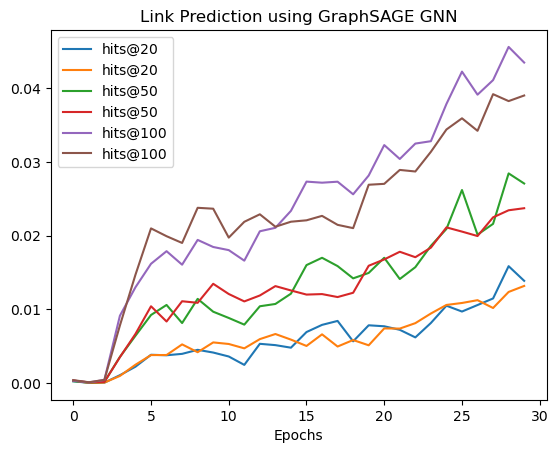

In [91]:
plt.title('Link Prediction using GraphSAGE GNN')
plt.plot(hits_20,label="hits@20")
plt.plot(hits_50,label="hits@50")
plt.plot(hits_100,label="hits@100")
plt.xlabel('Epochs')
plt.legend()
plt.show()

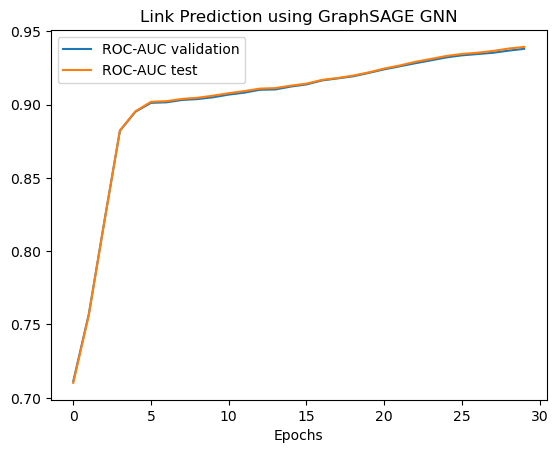

In [92]:
plt.title('Link Prediction using GraphSAGE GNN')
plt.plot(roc_auc_val,label="ROC-AUC validation")
plt.plot(roc_auc_test,label="ROC-AUC test")
plt.xlabel('Epochs')
plt.legend()
plt.show()